<a href="https://colab.research.google.com/github/kothawadegs/Deep-Learning/blob/master/Version%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


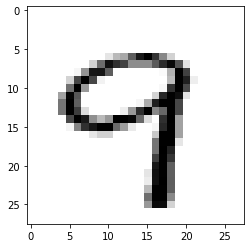

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

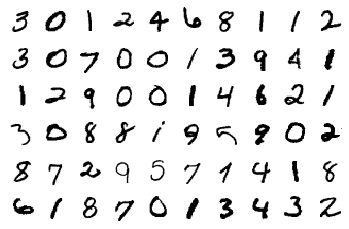

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             900
              ReLU-4           [-1, 10, 24, 24]               0
            Conv2d-5           [-1, 20, 22, 22]           1,800
              ReLU-6           [-1, 20, 22, 22]               0
         MaxPool2d-7           [-1, 20, 11, 11]               0
            Conv2d-8           [-1, 10, 11, 11]             200
              ReLU-9           [-1, 10, 11, 11]               0
           Conv2d-10             [-1, 10, 9, 9]             900
             ReLU-11             [-1, 10, 9, 9]               0
           Conv2d-12             [-1, 20, 7, 7]           1,800
             ReLU-13             [-1, 20, 7, 7]               0
           Conv2d-14             [-

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Loss=2.3026599884033203 Batch_id=0 Accuracy=14.06:   0%|          | 1/938 [00:00<02:04,  7.51it/s]

EPOCH: 0


Loss=0.0652887299656868 Batch_id=937 Accuracy=68.58: 100%|██████████| 938/938 [01:20<00:00, 10.85it/s]
Loss=0.14178012311458588 Batch_id=1 Accuracy=94.53:   0%|          | 2/938 [00:00<01:17, 12.14it/s]


Test set: Average loss: 0.1078, Accuracy: 9681/10000 (96.81%)

EPOCH: 1


Loss=0.18504175543785095 Batch_id=937 Accuracy=96.90: 100%|██████████| 938/938 [01:26<00:00, 10.61it/s]
Loss=0.0583263598382473 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:22, 11.36it/s]


Test set: Average loss: 0.0855, Accuracy: 9739/10000 (97.39%)

EPOCH: 2


Loss=0.043744537979364395 Batch_id=937 Accuracy=97.79: 100%|██████████| 938/938 [01:24<00:00, 11.14it/s]
Loss=0.012059378437697887 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:18, 11.88it/s]


Test set: Average loss: 0.0532, Accuracy: 9828/10000 (98.28%)

EPOCH: 3


Loss=0.010348038747906685 Batch_id=937 Accuracy=98.21: 100%|██████████| 938/938 [01:26<00:00, 11.85it/s]
Loss=0.02756720408797264 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:24, 11.04it/s]


Test set: Average loss: 0.0516, Accuracy: 9843/10000 (98.43%)

EPOCH: 4


Loss=0.018527910113334656 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [01:24<00:00, 11.53it/s]
Loss=0.08978304266929626 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:21, 11.47it/s]


Test set: Average loss: 0.0491, Accuracy: 9843/10000 (98.43%)

EPOCH: 5


Loss=0.00195982470177114 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [01:24<00:00, 12.16it/s]
Loss=0.01323341578245163 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:24, 11.11it/s]


Test set: Average loss: 0.0415, Accuracy: 9878/10000 (98.78%)

EPOCH: 6


Loss=0.003939424175769091 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [01:24<00:00, 11.40it/s]
Loss=0.04155239462852478 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:25, 10.95it/s]


Test set: Average loss: 0.0355, Accuracy: 9889/10000 (98.89%)

EPOCH: 7


Loss=0.0011119212722405791 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [01:24<00:00, 12.55it/s]
Loss=0.06337547302246094 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:22, 11.33it/s]


Test set: Average loss: 0.0434, Accuracy: 9870/10000 (98.70%)

EPOCH: 8


Loss=0.0077756429091095924 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [01:22<00:00, 11.85it/s]
Loss=0.0020185376051813364 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:19, 11.81it/s]


Test set: Average loss: 0.0432, Accuracy: 9851/10000 (98.51%)

EPOCH: 9


Loss=0.010092991404235363 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [01:19<00:00, 12.95it/s]
Loss=0.003466994734480977 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:13, 12.66it/s]


Test set: Average loss: 0.0407, Accuracy: 9877/10000 (98.77%)

EPOCH: 10


Loss=0.003210713854059577 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [01:20<00:00, 12.62it/s]
Loss=0.0037157125771045685 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:16, 12.17it/s]


Test set: Average loss: 0.0358, Accuracy: 9883/10000 (98.83%)

EPOCH: 11


Loss=0.12794406712055206 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [01:19<00:00, 12.80it/s]
Loss=0.05281040072441101 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:20, 11.60it/s]


Test set: Average loss: 0.0361, Accuracy: 9884/10000 (98.84%)

EPOCH: 12


Loss=0.05210253596305847 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [01:19<00:00, 13.10it/s]
Loss=0.03996790200471878 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:13, 12.75it/s]


Test set: Average loss: 0.0379, Accuracy: 9885/10000 (98.85%)

EPOCH: 13


Loss=0.0001863148354459554 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [01:17<00:00, 12.40it/s]
Loss=0.016014263033866882 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:11, 13.00it/s]


Test set: Average loss: 0.0374, Accuracy: 9889/10000 (98.89%)

EPOCH: 14


Loss=0.04968804866075516 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [01:16<00:00, 13.52it/s]



Test set: Average loss: 0.0375, Accuracy: 9894/10000 (98.94%)

